### Analyze the 2 color, 2 channel dataset acquired at North Western Univeristy.
reconstruction results are stored on LC:   <font color='blue'>/p/lscratchh/yi10/PRIS</font> 

In [2]:
import sys
sys.path.append("/g/g92/yi10/PyPRIS")
from PyPRIS import *

### Datasets
- Total number of full images: 17
- Each full image has 24 tiles.
- Each tile has 2 converging threshold values, 15 or 17.





In [3]:
p1 = '/p/lscratchh/yi10/PRIS' # path to all images.
p_ims=next(os.walk(p1))[1] # The directories for the reconstruction of each image.


In [4]:
# folders for all the full images
p_ims

['PyPRIS_V1F1_top100_tiles_50kIt',
 'PyPRIS_V2F290_top100_tiles_50kIt',
 'PyPRIS_V3F390_top100_tiles_50kIt',
 'PyPRIS_V4F406_top100_tiles_50kIt',
 'PyPRIS_V2F500_top100_tiles_50kIt',
 'PyPRIS_V2F472_top100_tiles_50kIt',
 'PyPRIS_V1F3_top100_tiles_50kIt',
 'PyPRIS_V1F558_top100_tiles_50kIt',
 'PyPRIS_V2F300_top100_tiles_50kIt',
 'PyPRIS_V3F430_top100_tiles_50kIt',
 'PyPRIS_V1F505_top100_tiles_50kIt',
 'PyPRIS_V3F410_top100_tiles_50kIt',
 'PyPRIS_V1F2_top100_tiles_50kIt',
 'PyPRIS_V2F452_top100_tiles_50kIt',
 'PyPRIS_V1F534_top100_tiles_50kIt',
 'PyPRIS_V2F276_top100_tiles_50kIt',
 'PyPRIS_V4F437_top100_tiles_50kIt']

In [5]:
# 24 pris tiles for each full image
next(os.walk(p1+'/'+p_ims[0]))[1]

['bgSCF8_mu1.0e+02_alpha1.0e-09_thres-15_c08_zrange-100to100_yrange35to80_xrange35to80',
 'bgSCF8_mu1.0e+02_alpha1.0e-09_thres-17_c19_zrange-100to100_yrange105to140_xrange1to45',
 'bgSCF8_mu1.0e+02_alpha1.0e-09_thres-17_c17_zrange-100to100_yrange70to115_xrange130to175',
 'bgSCF8_mu1.0e+02_alpha1.0e-09_thres-17_c12_zrange-100to100_yrange35to80_xrange165to212',
 'bgSCF8_mu1.0e+02_alpha1.0e-09_thres-15_c02_zrange-100to100_yrange1to45_xrange35to80',
 'bgSCF8_mu1.0e+02_alpha1.0e-09_thres-17_c11_zrange-100to100_yrange35to80_xrange130to175',
 'bgSCF8_mu1.0e+02_alpha1.0e-09_thres-17_c07_zrange-100to100_yrange35to80_xrange1to45',
 'bgSCF8_mu1.0e+02_alpha1.0e-09_thres-15_c21_zrange-100to100_yrange105to140_xrange70to110',
 'bgSCF8_mu1.0e+02_alpha1.0e-09_thres-15_c22_zrange-100to100_yrange105to140_xrange105to140',
 'bgSCF8_mu1.0e+02_alpha1.0e-09_thres-17_c04_zrange-100to100_yrange1to45_xrange105to140',
 'bgSCF8_mu1.0e+02_alpha1.0e-09_thres-15_c15_zrange-100to100_yrange70to115_xrange70to110',
 'bgS

Every dataset should have a pandas dataframe, to store the following information:

For each Tile and each PRIS iteration number, get the file names for 
- (a) the linbreg object with the last iteration number, 
- (b) the sensing matrix, and 
- (c) the pris object 



### Handle for 1 full image

In [19]:
# handle for 1 full image:
path=p1+'/'+p_ims[1]

# get the list of folders for different condition
thres17=list()
thres15=list()
for count in ['c'+str(x+1).zfill(2) for x in np.arange(24,dtype='int')]:
    for file in next(os.walk(path))[1]:
        if count in file and 'thres-17' in file:
            thres17.append(path+'/'+file)
        elif count in file and 'thres-15' in file:
            thres15.append(path+'/'+file)

# start a dataframe to store data for this full image recovery files.
data = pd.DataFrame(columns=['thres15','thres17'], 
                   index = ['pris'+str(x) for x in np.arange(7)])
for index,row in data.iterrows():
    data['thres15'][index]=list()
    data['thres17'][index]=list() 



# assign dataframe element values, each value is the list of file names for each condition.
for thresv in [15, 17]:
    exec('thresN=thres'+str(thresv))
    for count_fp in thresN: # loop over count_fp: the index of tiles.
        # get all the .file filenames for current thres, and sort the file names into dataframe
        objs=next(os.walk(count_fp+'/saved_objects'))[2]
        k='thres'+str(thresv)
        d=fetch_saved_objects(path=count_fp+'/saved_objects', key=k)
        for p in list(d.index):
            data['thres'+str(thresv)][p].append(d['thres'+str(thresv)][p])

print(data['thres17']['pris2'][19]['linbreg'].split('/')[-1])
print(data['thres15']['pris0'][0]['sensing matrix'].split('/')[-1])
print(data['thres15']['pris0'][0]['pris'].split('/')[-1])


PyPRIS_bgSCF8_mu1.0e+02_alpha1.0e-09_thres-17_c20_zrange-100to100_yrange105to140_xrange35to80_pris1_1354.file
PyPRIS_bgSCF8_mu1.0e+02_alpha1.0e-09_thres-15_c01_zrange-100to100_yrange1to45_xrange1to45_pris0_SensingMx.file
PyPRIS_pris0.file



get the recovered x and the location coordiantes form each tile, and 
- generate the recovered blur tile 
- concatenate the x with other x, to get the larger volume.
- get the 3D recovery of the overall big volume


tile0
tile1
tile2
tile3
tile4
tile5
tile6
tile7
tile8
tile9
tile10
tile11
tile12
tile13
tile14
tile15
tile16
tile17


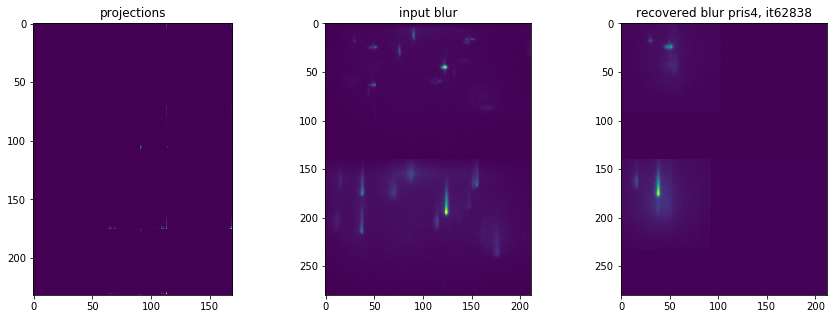

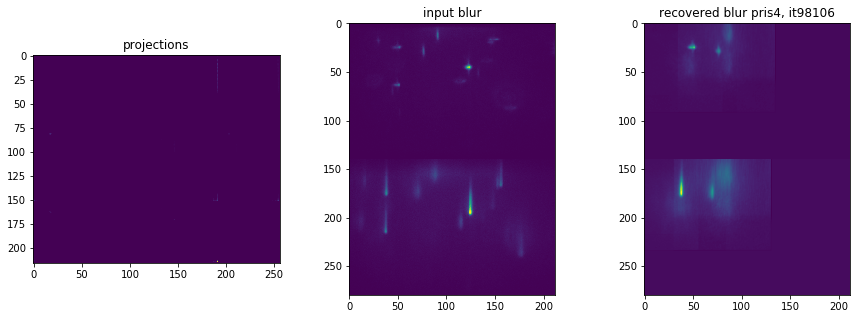

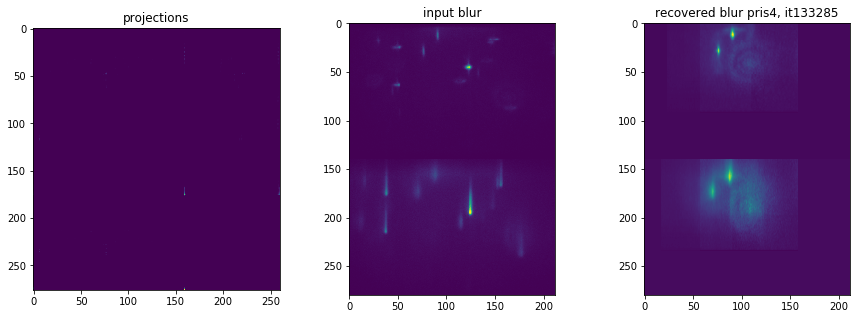

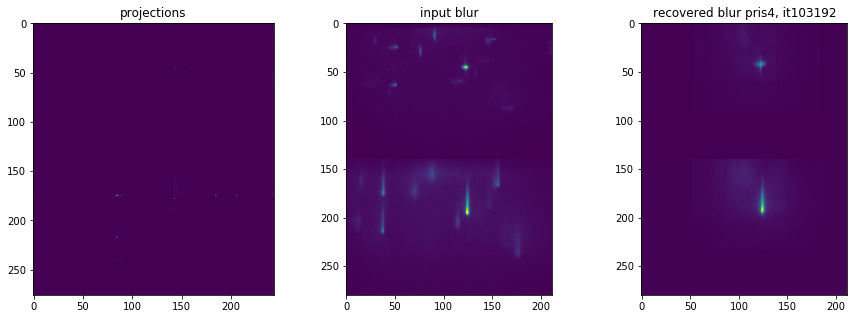

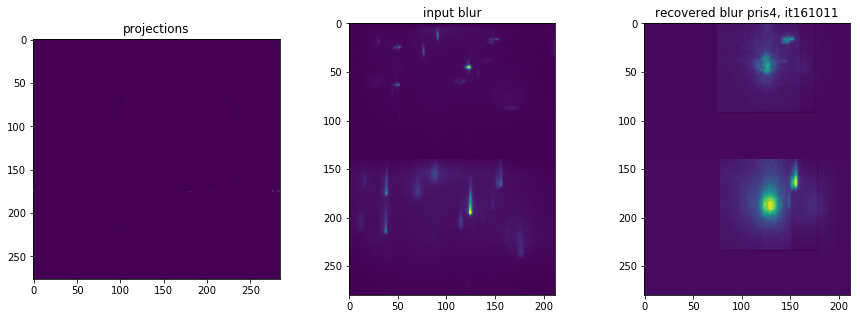

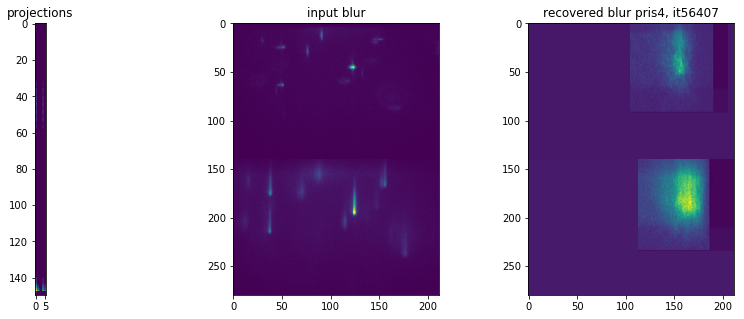

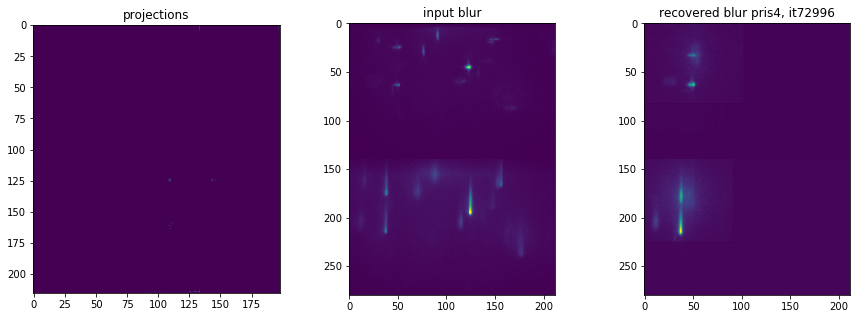

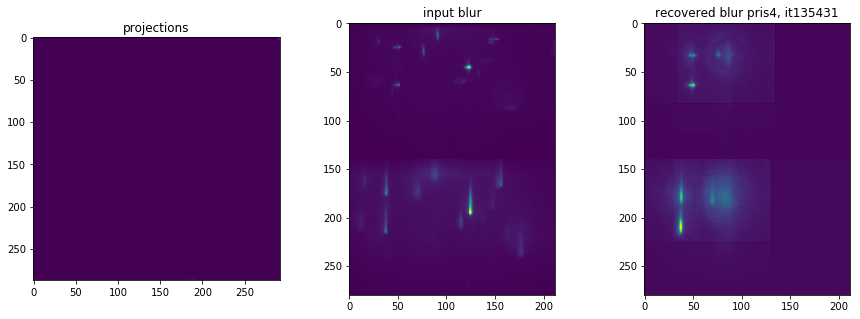

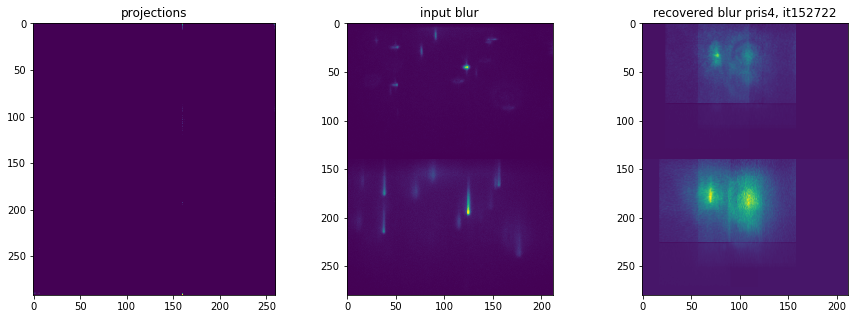

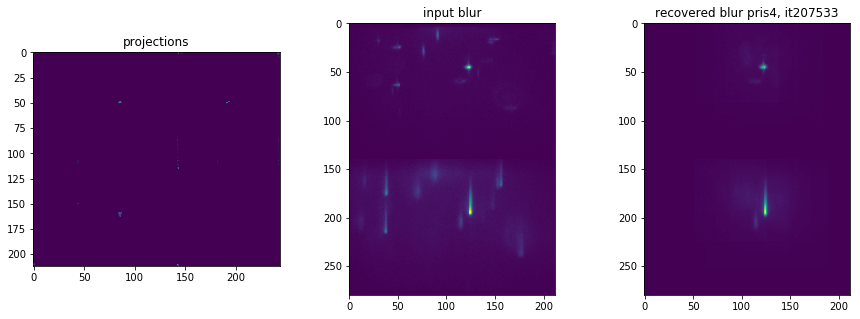

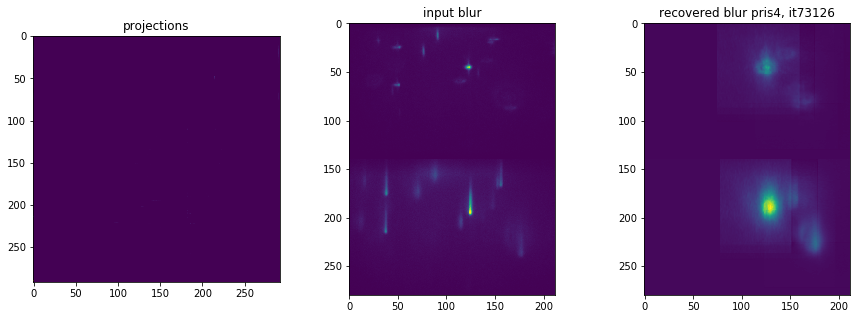

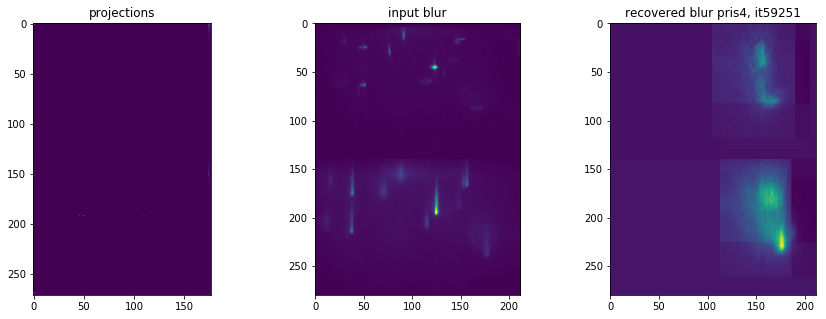

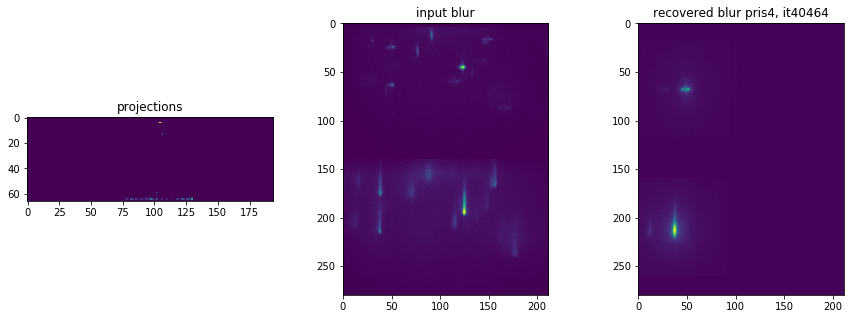

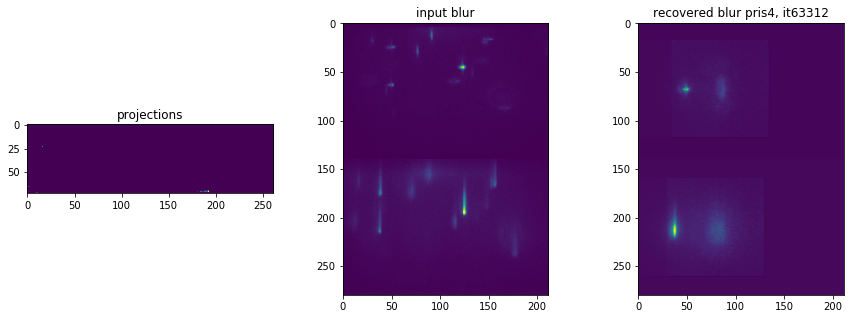

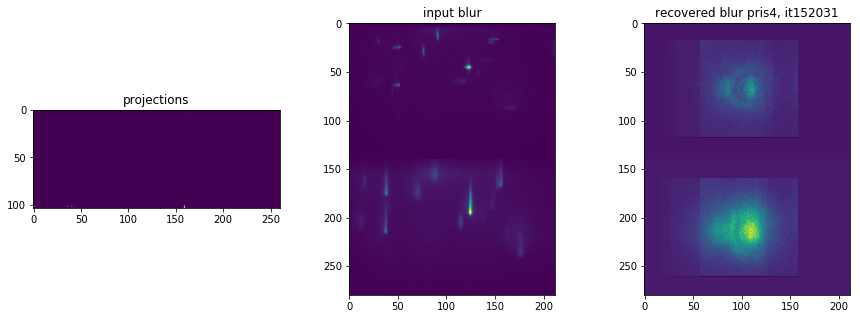

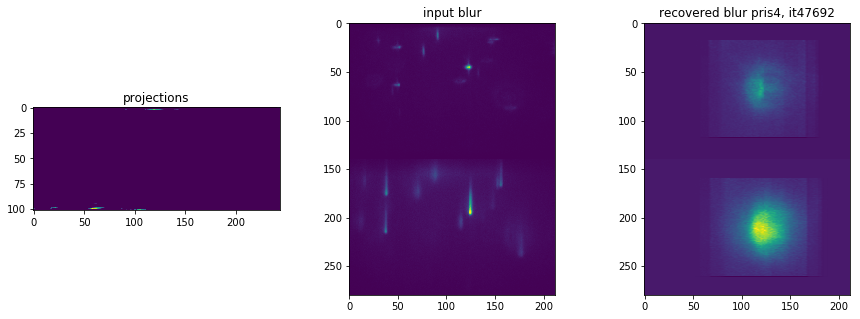

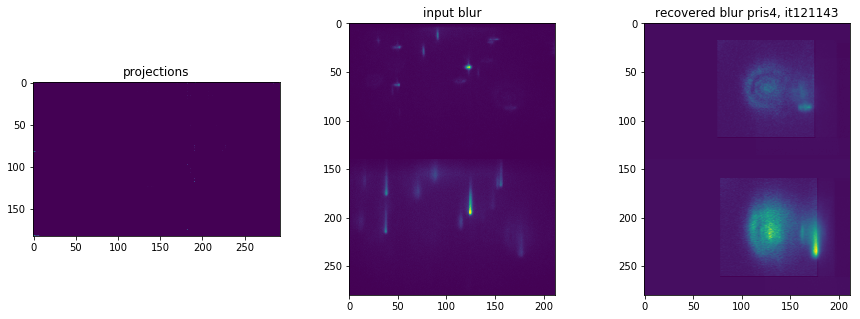

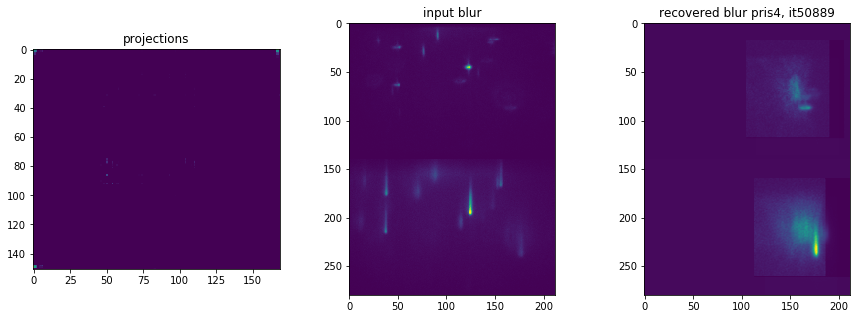

In [22]:
blist=[]
recblist=[]
catlist=[]
pj0list=[]
pj1list=[]
pj2list=[]
pristag='pris4'
cindrange=len(data['thres17'][pristag])
for cind in np.arange(cindrange):
    with open(data['thres17']['pris4'][cind]['linbreg'],'rb') as f:
        a=pickle.load(f)
        [b, recb, cat, pj0, pj1, pj2] = linbreg_report(a,msg='tile'+str(cind))
        blist.append(b)
        recblist.append(recb)
        catlist.append(cat)
        pj0list.append(pj0)
        pj1list.append(pj1)
        pj2list.append(pj2)


In [1]:
x=data['thres17']['pris5']
len(x)

NameError: name 'data' is not defined

    
with open(data['thres15']['pris0'][0]['pris'],'rb') as f:
    b=pickle.load(f)
    
with open(data['thres15']['pris0'][0]['sensing matrix'],'rb') as f:
    c=joblib.load(f)

In [ ]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.imshow(b)
plt.subplot(1,3,2)
plt.imshow(sum(recblist))


# when you finish making this note book, delete the last line in the .gitignore file, and push the modifications to the repository.

In [ ]:
a.it_count

In [11]:
x=data['thres15']['pris3']
len(x)

18